<a href="https://colab.research.google.com/github/nicobonacorsi/PMML-PROJECT-COLUMBIA/blob/main/COLLATZ_PAPER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model 1 — Hierarchical NB2-GLM (PyMC)

This notebook is **runnable from scratch** and performs:
1. Compute Collatz total stopping times τ(n) for 1 ≤ n ≤ N using Numba + dynamic programming.
2. Build a full dataset (n, τ(n)) and engineer features (log_n, v2, mod8).
3. Fit a hierarchical Negative Binomial regression (mod 8 random effects).
4. Posterior predictive checks + log predictive score + Wasserstein distance.




## Install dependencies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

from numba import njit

sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["figure.dpi"] = 120

## 1. τ(n) computation (Numba + dynamic programming)


In [ ]:
# Numba function for τ(n) with dynamic programming

@njit
def compute_tau_numba(N: int):
    """
    Compute total stopping times τ(n) for all integers 1 ≤ n ≤ N.

    Optimizations:
      - Numba @njit to compile to machine code.
      - Dynamic programming: when the trajectory of i reaches
        a value n < i, reuse the previously computed τ(n).

    Parameters
    ----------
    N : int
        Upper bound (inclusive) for starting values.

    Returns
    -------
    tau_values : np.ndarray of shape (N,)
        tau_values[i-1] = τ(i) for i = 1,...,N, dtype int32.
    """
    tau_values = np.zeros(N, dtype=np.int32)
    tau_values[0] = 0  # τ(1) = 0

    for i in range(2, N + 1):
        n = i
        steps = 0

        while n != 1:
            # If the trajectory enters a value < i, we can use the cache
            if n < i:
                steps += tau_values[n - 1]
                break

            # Collatz step (bitwise parity test)
            if (n & 1) == 0:   # even
                n = n // 2
            else:              # odd
                n = 3 * n + 1

            steps += 1

        tau_values[i - 1] = steps

    return tau_values

print("compute_tau_numba defined.")



compute_tau_numba defined.


In [ ]:
# Compute τ(n) for 1 ≤ n ≤ 10,000,000

N = 10_000_000
print(f"Computing τ(n) for 1 ≤ n ≤ {N:,} ...")

# Run (compilation + execution)
tau_values = compute_tau_numba(N)

print("Done.")
print("First 10 values of τ(n):")
for i in range(1, 11):
    print(f"n = {i:2d}, τ(n) = {tau_values[i-1]}")


Computing τ(n) for 1 ≤ n ≤ 10,000,000 ...
Done.
First 10 values of τ(n):
n =  1, τ(n) = 0
n =  2, τ(n) = 1
n =  3, τ(n) = 7
n =  4, τ(n) = 2
n =  5, τ(n) = 5
n =  6, τ(n) = 8
n =  7, τ(n) = 16
n =  8, τ(n) = 3
n =  9, τ(n) = 19
n = 10, τ(n) = 6


## 2. Build dataset + basic summary


In [ ]:
# DataFrame, basic summary statistics, tabular saving

# Build the n column
n_values = np.arange(1, N + 1, dtype=np.int64)

# Main DataFrame
df = pd.DataFrame({"n": n_values, "tau": tau_values})

# Basic statistics
tau_min = df["tau"].min()
tau_max = df["tau"].max()
tau_mean = df["tau"].mean()
tau_var = df["tau"].var(ddof=0)  # population variance
ratio_var_mean = tau_var / tau_mean

print("=== Basic summary for τ(n), 1 ≤ n ≤ N ===")
print(f"N observations        : {len(df):,}")
print(f"tau_min              : {tau_min}")
print(f"tau_max              : {tau_max}")
print(f"Empirical mean E[τ]  : {tau_mean:.3f}")
print(f"Empirical Var(τ)     : {tau_var:.3f}")
print(f"Var / Mean           : {ratio_var_mean:.3f}")


=== Basic summary for τ(n), 1 ≤ n ≤ N ===
N observations        : 10,000,000
tau_min              : 0
tau_max              : 685
Empirical mean E[τ]  : 155.272
Empirical Var(τ)     : 3814.045
Var / Mean           : 24.564


## 3. Exploratory plots (distribution + τ(n) vs n)


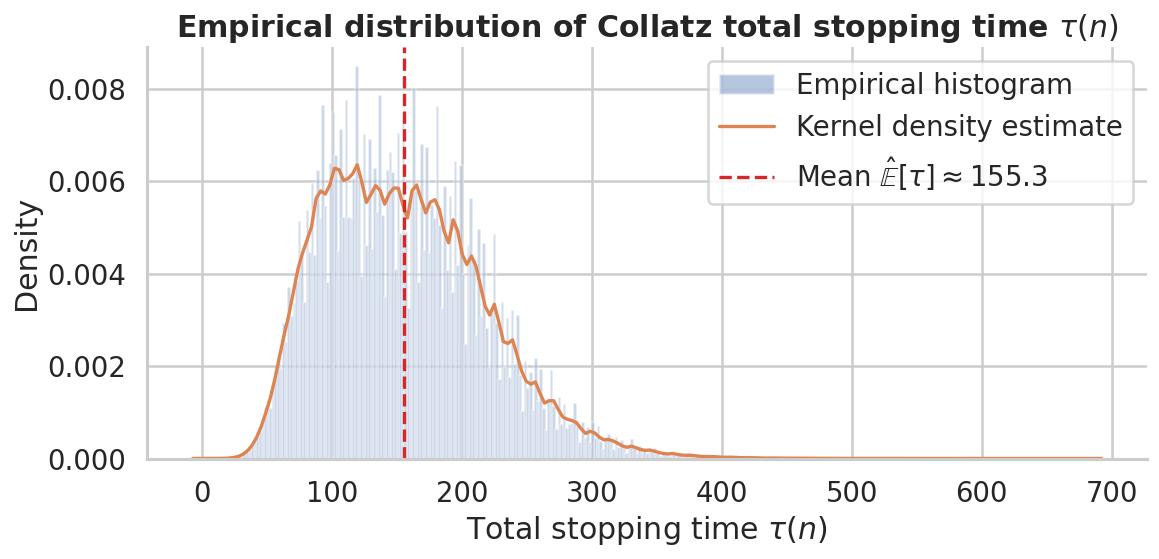

In [ ]:
# Histogram + KDE of the distribution of τ(n)

# Integer-aligned bins, width 2 to reduce visual noise
bins = np.arange(tau_min - 0.5, tau_max + 1.5, 2)

plt.figure(figsize=(10, 5))

# Normalized histogram (density)
plt.hist(
    df["tau"],
    bins=bins,
    density=True,
    alpha=0.4,
    label="Empirical histogram"
)

# Smoothed KDE (Seaborn)
sns.kdeplot(
    data=df,
    x="tau",
    bw_adjust=1.0,
    linewidth=2,
    label="Kernel density estimate"
)

# Vertical line at the mean
plt.axvline(
    tau_mean,
    linestyle="--",
    linewidth=2,
    color="tab:red",
    label=fr"Mean $\hat{{\mathbb{{E}}}}[\tau] \approx {tau_mean:.1f}$"
)

plt.title(r"Empirical distribution of Collatz total stopping time $\tau(n)$")
plt.xlabel(r"Total stopping time $\tau(n)$")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


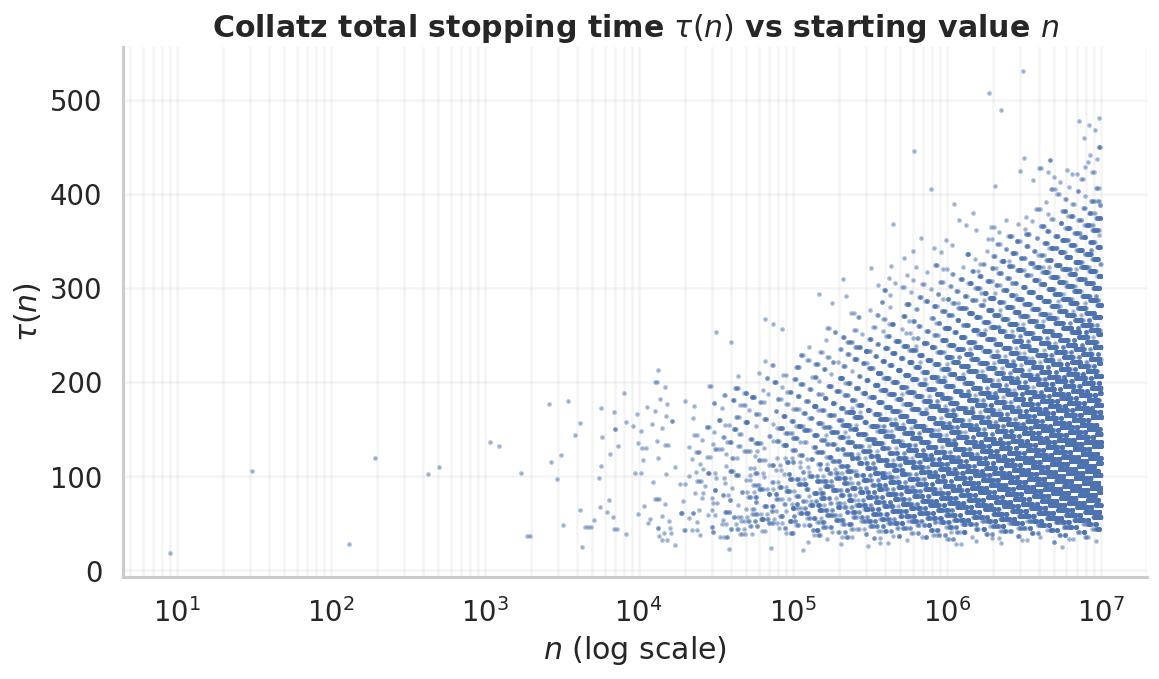

In [ ]:
# Scatter plot τ(n) vs n (log-scale)

# To avoid plotting 10 million points, we take a subsample
sample_size_scatter = 50_000
rng = np.random.default_rng(seed=42)
sample_idx = rng.choice(df.index.to_numpy(), size=sample_size_scatter, replace=False)
df_scatter = df.loc[sample_idx]

plt.figure(figsize=(10, 6))
plt.scatter(
    df_scatter["n"],
    df_scatter["tau"],
    s=2,
    alpha=0.4
)

plt.xscale("log")
plt.title(r"Collatz total stopping time $\tau(n)$ vs starting value $n$")
plt.xlabel(r"$n$ (log scale)")
plt.ylabel(r"$\tau(n)$")
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.tight_layout()
plt.show()


## 4. Feature engineering + train/test split


In [ ]:

# Feature engineering + subsample for the Bayesian model

# 1. log(n)
df["log_n"] = np.log(df["n"].to_numpy(dtype=np.float64))

# 2. v2(n): number of factors of 2 (binary trailing zeros)
#    using the fact that n & -n = 2^{v2(n)}
n_arr = df["n"].to_numpy(dtype=np.int64)
lowest_power_two = n_arr & -n_arr         # = 2^{v2(n)}
v2_vals = np.log2(lowest_power_two).astype(np.int8)
df["v2"] = v2_vals

# 3. residue class mod 8
df["mod8"] = (df["n"] % 8).astype(np.int8)

print("Feature columns added: 'log_n', 'v2', 'mod8'")
print(df[["n", "tau", "log_n", "v2", "mod8"]].head())

# 4. Subsample for the Bayesian model
N_fit  = 50_000   # for PyMC fitting
N_test = 50_000   # for posterior predictive checks

rng = np.random.default_rng(seed=123)

all_idx = df.index.to_numpy()

fit_idx = rng.choice(all_idx, size=N_fit, replace=False)
df_fit = df.loc[fit_idx].copy()

rest_idx = np.setdiff1d(all_idx, fit_idx, assume_unique=True)
test_idx = rng.choice(rest_idx, size=N_test, replace=False)
df_test = df.loc[test_idx].copy()

print("\nSubsample sizes:")
print("  df_fit  :", df_fit.shape)
print("  df_test :", df_test.shape)

print("\nSummary tau in df_fit:")
print(df_fit["tau"].describe())

print("\nSummary tau in df_test:")
print(df_test["tau"].describe())

# Arrays (same variable names as yours)
y_fit    = df_fit["tau"].to_numpy(dtype=np.int64)
logn_fit = df_fit["log_n"].to_numpy(dtype=np.float64)
mod8_fit = df_fit["mod8"].to_numpy(dtype=np.int64)

y_test    = df_test["tau"].to_numpy(dtype=np.int64)
logn_test = df_test["log_n"].to_numpy(dtype=np.float64)
mod8_test = df_test["mod8"].to_numpy(dtype=np.int64)

print("Shapes for M3:")
print("  y_fit     :", y_fit.shape)
print("  logn_fit  :", logn_fit.shape)
print("  mod8_fit  :", mod8_fit.shape)
print("  y_test    :", y_test.shape)
print("  logn_test :", logn_test.shape)
print("  mod8_test :", mod8_test.shape)

print("\nUnique values in mod8_fit :", np.unique(mod8_fit))
print("Unique values in mod8_test:", np.unique(mod8_test))

Feature columns added: 'log_n', 'v2', 'mod8'
   n  tau     log_n  v2  mod8
0  1    0  0.000000   0     1
1  2    1  0.693147   1     2
2  3    7  1.098612   0     3
3  4    2  1.386294   2     4
4  5    5  1.609438   0     5

Subsample sizes:
  df_fit  : (50000, 5)
  df_test : (50000, 5)

Summary tau in df_fit:
count    50000.000000
mean       155.650740
std         62.044514
min         15.000000
25%        106.000000
50%        150.000000
75%        196.000000
max        537.000000
Name: tau, dtype: float64

Summary tau in df_test:
count    50000.000000
mean       154.773000
std         61.376614
min         22.000000
25%        106.000000
50%        149.000000
75%        195.000000
max        529.000000
Name: tau, dtype: float64
Shapes for M3:
  y_fit     : (50000,)
  logn_fit  : (50000,)
  mod8_fit  : (50000,)
  y_test    : (50000,)
  logn_test : (50000,)
  mod8_test : (50000,)

Unique values in mod8_fit : [0 1 2 3 4 5 6 7]
Unique values in mod8_test: [0 1 2 3 4 5 6 7]


## 5. Model M3 — Hierarchical NB regression (mod 8)


In [ ]:
# Cell M3-Model — Bayesian NB regression M3 (hierarchical mod 8)
import pymc as pm
import arviz as az

with pm.Model() as model_m3:
    # Priors on the "global" coefficients
    beta0_m3 = pm.Normal("beta0_m3", mu=0.0, sigma=10.0)
    beta_log_m3 = pm.Normal("beta_log_m3", mu=0.0, sigma=5.0)

    # Random effects for the 8 residue classes mod 8
    # u_r ~ N(0, sigma_u^2), r = 0,...,7
    sigma_u = pm.HalfNormal("sigma_u", sigma=1.0)
    u_raw = pm.Normal("u_raw", mu=0.0, sigma=1.0, shape=8)
    u = pm.Deterministic("u", u_raw * sigma_u)  # u[r] = effect for class r

    # Overdispersion under the "paper" parameterization
    # Var(Y|mu,alpha_paper) = mu + alpha_paper * mu^2
    # PyMC uses Var = mu + mu^2 / alpha_nb  =>  alpha_nb = 1 / alpha_paper
    alpha_paper_m3 = pm.HalfNormal("alpha_paper_m3", sigma=5.0)
    alpha_nb_m3 = pm.Deterministic("alpha_nb_m3", 1.0 / alpha_paper_m3)

    # Linear predictor and mean
    # eta_n = beta0 + beta_log * log(n) + u_{mod8(n)}
    eta_m3 = beta0_m3 + beta_log_m3 * logn_fit + u[mod8_fit]
    mu_m3 = pm.math.exp(eta_m3)

    # Negative Binomial likelihood
    y_obs_m3 = pm.NegativeBinomial(
        "y_obs_m3",
        mu=mu_m3,
        alpha=alpha_nb_m3,
        observed=y_fit,
    )

    # MCMC with NUTS
    idata_m3 = pm.sample(
        draws=1000,
        tune=1000,
        chains=2,
        cores=2,
        target_accept=0.9,
        random_seed=321,
        progressbar=True,
    )

print("Sampling M3 completed.")


az.summary(idata_m3)




Output()

Sampling M3 completed.
Saved M3 inference data to 'collatz_nb_M3_idata.nc'.


## 6. Posterior predictive checks (train + test)


Train set (M3): empirical mean/var vs posterior predictive:
  Empirical mean : 155.65074   var: 3849.4447574523997
  PPC mean       : 155.65507598   var: 3953.0318831404256

TEST set: empirical mean / var vs posterior predictive (M3)
  Empirical mean : 154.773   var: 3767.013351
  Predictive mean: 155.81978946666666   var: 3959.4990737636776


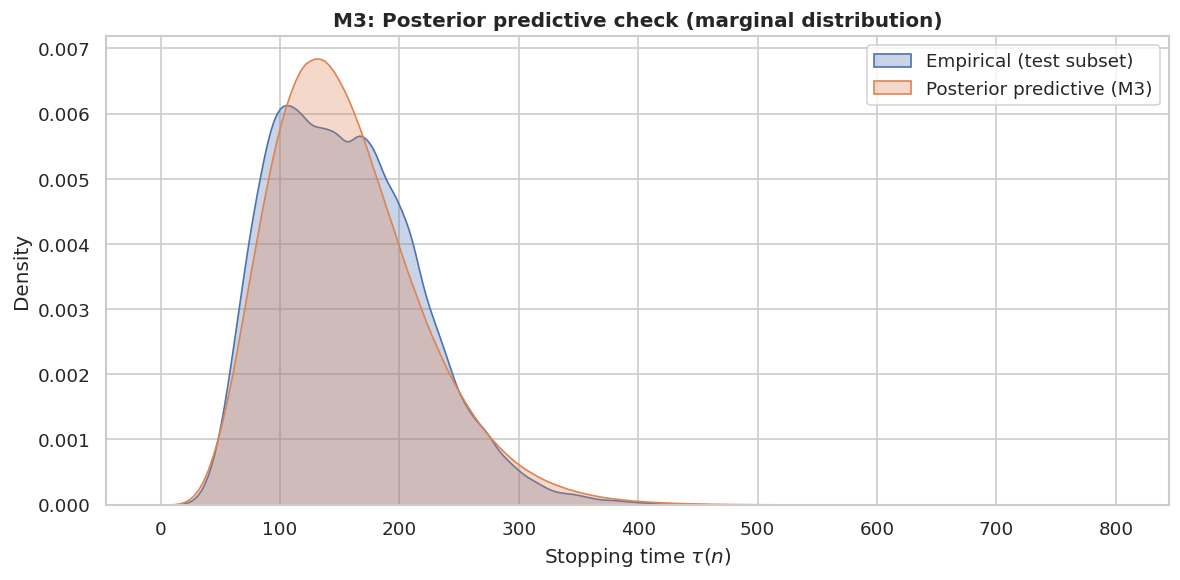

In [ ]:
# Cell M3-PPC — Posterior predictive check for M3
from scipy.stats import nbinom

sns.set_theme(style="whitegrid")

# 1) PPC on the TRAIN set
with model_m3:
    ppc_train_m3 = pm.sample_posterior_predictive(
        idata_m3,
        var_names=["y_obs_m3"],
        random_seed=123,
        progressbar=False,
        return_inferencedata=False,
    )

y_train_ppc_m3 = ppc_train_m3["y_obs_m3"].reshape(-1)

print("Train set (M3): empirical mean/var vs posterior predictive:")
print("  Empirical mean :", y_fit.mean(), "  var:", y_fit.var(ddof=0))
print("  PPC mean       :", y_train_ppc_m3.mean(), "  var:", y_train_ppc_m3.var(ddof=0))

# 2) PPC on the TEST set (true generalization)

posterior_m3 = idata_m3.posterior

# Posterior samples and flatten (chain, draw) -> (S_tot,)
beta0_samples       = posterior_m3["beta0_m3"].values          # (chains, draws)
beta_log_samples    = posterior_m3["beta_log_m3"].values       # (chains, draws)
u_samples           = posterior_m3["u"].values                 # (chains, draws, 8)
alpha_paper_samples = posterior_m3["alpha_paper_m3"].values    # (chains, draws)

beta0_flat       = beta0_samples.reshape(-1)        # (S_tot,)
beta_log_flat    = beta_log_samples.reshape(-1)     # (S_tot,)
alpha_paper_flat = alpha_paper_samples.reshape(-1)  # (S_tot,)
u_flat           = u_samples.reshape(-1, 8)         # (S_tot, 8)

S_tot = beta0_flat.shape[0]
S = min(300, S_tot)   # as in M2: 300 draws for a robust PPC

rng = np.random.default_rng(seed=456)
idx = rng.choice(S_tot, size=S, replace=False)

beta0_s       = beta0_flat[idx]        # (S,)
beta_log_s    = beta_log_flat[idx]     # (S,)
alpha_paper_s = alpha_paper_flat[idx]  # (S,)
u_s           = u_flat[idx, :]         # (S, 8)

N_test = len(y_test)

# eta_test_m3(n,s) = beta0_s[s] + beta_log_s[s] * logn_test[n] + u_s[s, mod8_test[n]]
# eta_test_m3: shape (N_test, S)
eta_test_m3 = (
    beta0_s[None, :] +
    beta_log_s[None, :] * logn_test[:, None] +
    u_s[:, mod8_test].T          # (S, N_test) -> .T -> (N_test, S)
)

mu_test_m3 = np.exp(eta_test_m3)       # (N_test, S)

# NB2 parameterization:
# Var = mu + alpha_paper * mu^2
# mapping to SciPy nbinom: r = 1/alpha, p = 1 / (1 + alpha * mu)
r_s = 1.0 / alpha_paper_s              # (S,)
r_mat = r_s[None, :]                   # (1, S)
p_mat = 1.0 / (1.0 + alpha_paper_s[None, :] * mu_test_m3)  # (N_test, S)

# Sample y_sim_m3 ~ NB(r_mat, p_mat)
y_sim_m3 = nbinom.rvs(r_mat, p_mat, random_state=789)      # (N_test, S)
y_sim_flat_m3 = y_sim_m3.reshape(-1)

# Empirical and predictive moments on the TEST set
mean_emp = y_test.mean()
var_emp  = y_test.var(ddof=0)

mean_pred = y_sim_flat_m3.mean()
var_pred  = y_sim_flat_m3.var(ddof=0)

print("\nTEST set: empirical mean / var vs posterior predictive (M3)")
print("  Empirical mean :", mean_emp, "  var:", var_emp)
print("  Predictive mean:", mean_pred, "  var:", var_pred)

# 3) Marginal KDE plot (test set, M3)
plt.figure(figsize=(10, 5))
sns.kdeplot(y_test,        label="Empirical (test subset)",   fill=True, alpha=0.3)
sns.kdeplot(y_sim_flat_m3, label="Posterior predictive (M3)", fill=True, alpha=0.3)
plt.title("M3: Posterior predictive check (marginal distribution)")
plt.xlabel(r"Stopping time $\tau(n)$")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.savefig("fig_m3_ppc_marginal.png", dpi=150)
plt.show()



## 7. Predictive log score + Wasserstein distance (test set)


In [ ]:
from scipy.special import logsumexp
from scipy.stats import wasserstein_distance
from scipy.stats import nbinom

print(az.summary(idata_m3, var_names=["beta0_m3", "beta_log_m3", "alpha_paper_m3", "sigma_u"], hdi_prob=0.94))

# 1) Log predictive score on TEST for M3
# p(y_i | x_i, D) = average_s NB(y_i | mu_is, alpha_s)
posterior = idata_m3.posterior

beta0 = posterior["beta0_m3"].values.reshape(-1)
betaL = posterior["beta_log_m3"].values.reshape(-1)
alpha_paper = posterior["alpha_paper_m3"].values.reshape(-1)
u = posterior["u"].values.reshape(-1, 8)

S_tot = beta0.shape[0]
S = min(500, S_tot)  # 300–500 is fine
rng = np.random.default_rng(456)
idx = rng.choice(S_tot, size=S, replace=False)

beta0_s = beta0[idx]
betaL_s = betaL[idx]
alpha_s = alpha_paper[idx]
u_s = u[idx, :]

# mu_test: (N_test, S)
eta_test = (
    beta0_s[None, :]
    + betaL_s[None, :] * logn_test[:, None]
    + u_s[:, mod8_test].T
)
mu_test = np.exp(eta_test)

# SciPy NB: n=r=1/alpha, p=1/(1+alpha*mu)
r = (1.0 / alpha_s)[None, :]  # (1, S)
p = 1.0 / (1.0 + alpha_s[None, :] * mu_test)  # (N_test, S)

logpmf = nbinom.logpmf(y_test[:, None], r, p)  # (N_test, S)

# log mean exp across posterior draws
log_pred_i = logsumexp(logpmf, axis=1) - np.log(S)  # (N_test,)
log_score_m3 = np.sum(log_pred_i)

print("\nM3 log predictive score (TEST):", float(log_score_m3))
print("M3 avg log score per obs:", float(log_score_m3 / len(y_test)))

# -----------------------------
# 2) W1 (1-Wasserstein) between marginal distributions (TEST empirical vs predictive)
# -----------------------------

y_pred = nbinom.rvs(r, p, random_state=789).reshape(-1)

w1_m3 = wasserstein_distance(y_test, y_pred)
print("\nM3 W1 distance (TEST empirical vs predictive):", float(w1_m3))


                 mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta0_m3        3.962  0.045   3.880    4.048      0.002    0.002     440.0   
beta_log_m3     0.071  0.002   0.068    0.075      0.000    0.000     934.0   
alpha_paper_m3  0.146  0.001   0.144    0.148      0.000    0.000    1368.0   
sigma_u         0.094  0.031   0.047    0.151      0.002    0.001     395.0   

                ess_tail  r_hat  
beta0_m3           563.0   1.00  
beta_log_m3        930.0   1.00  
alpha_paper_m3    1109.0   1.00  
sigma_u            566.0   1.01  

M3 log predictive score (TEST): -272911.94917109434
M3 avg log score per obs: -5.458238983421887

M3 W1 distance (TEST emp vs predictive): 3.1990281200000017


# Model 2 — Generative modelling via odd-block lengths K = v2(3m+1)





## Imports + assumptions

In [ ]:
# METHOD 2 — Generative modelling via odd-block lengths K = v2(3m+1)
# Variants:
#   G1: geometric reference p_k = 2^{-k} (truncated)
#   G2: global Dirichlet posterior mean for p_k
#   G3: p_k conditional on residue class (m mod 8)

# Assumes Model 1 has already created df, df_fit, df_test (+ features).



import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import beta as beta_dist
from scipy.stats import wasserstein_distance

sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["figure.dpi"] = 120
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

assert "df" in globals(), "df not found. Run Model 1 first."
assert "df_test" in globals(), "df_test not found. Run Model 1 split first."
assert {"n", "tau"}.issubset(df.columns), "df must contain columns ['n','tau']."
assert "mod8" in df.columns, "df must contain 'mod8' (created in Model 1)."


## M2.1 — Estimate odd-block length distribution: $K = v_2(3m+1)$


In [ ]:
def v2_np(x: np.ndarray) -> np.ndarray:
    """Vectorized 2-adic valuation via lowest set bit."""
    lowbit = x & -x
    return np.log2(lowbit).astype(np.int32)

N = int(df["n"].max())
print("Using N =", f"{N:,}")

odd = np.arange(1, N + 1, 2, dtype=np.int64)
vals = 3 * odd + 1
K = v2_np(vals)  # K >= 1

K_max = 30
K_cap = np.minimum(K, K_max)

counts = np.bincount(K_cap, minlength=K_max + 1)
counts[0] = 0

pk_hat = counts / counts.sum()

print("First pk_hat:")
for k in range(1, 11):
    print(k, float(pk_hat[k]))

EK = sum(k * pk_hat[k] for k in range(1, K_max + 1))
print("E[K] approx:", float(EK))


Using N = 10,000,000
First pk_hat:
1 0.5
2 0.25
3 0.125
4 0.0625
5 0.03125
6 0.015625
7 0.0078124
8 0.0039064
9 0.001953
10 0.0009766
E[K] approx: 2.0000006


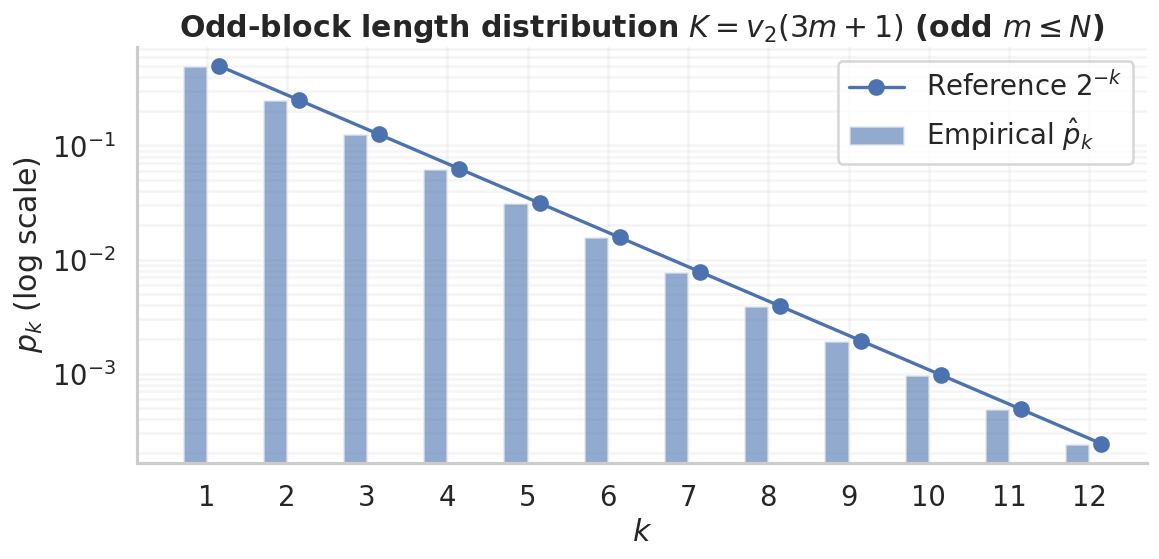

In [ ]:
k_plot = 12
ks = np.arange(1, k_plot + 1)
pk_emp = np.array([pk_hat[k] for k in ks])
pk_ref = 0.5 ** ks

plt.figure(figsize=(10, 5))
plt.bar(ks - 0.15, pk_emp, width=0.3, alpha=0.6, label=r"Empirical $\hat p_k$")
plt.plot(ks + 0.15, pk_ref, marker="o", linewidth=2, label=r"Reference $2^{-k}$")
plt.yscale("log")
plt.xticks(ks)
plt.title(r"Odd-block length distribution $K=v_2(3m+1)$ (odd $m\leq N$)")
plt.xlabel(r"$k$")
plt.ylabel(r"$p_k$ (log scale)")
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()
plt.tight_layout()

plt.show()


## M2.2 — Dirichlet posterior for $p_k$ (global)


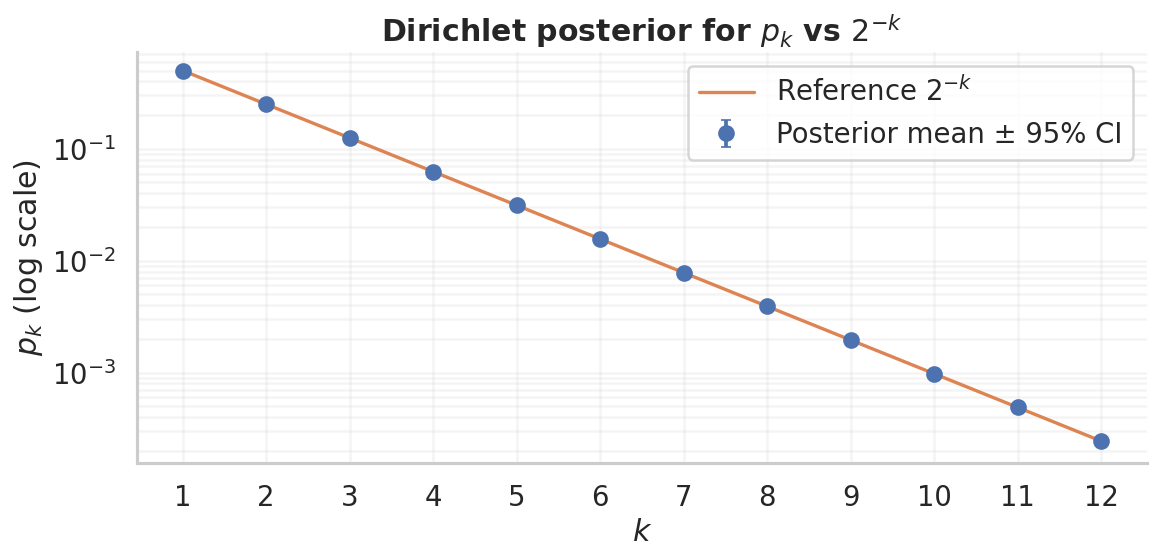

In [ ]:
alpha0 = np.ones(K_max + 1, dtype=float)
alpha0[0] = 0.0

alpha_post = alpha0 + counts.astype(float)
alpha_post[0] = 0.0
alpha_sum = alpha_post.sum()

p_post_mean = alpha_post / alpha_sum

ci_low = np.zeros(K_max + 1)
ci_high = np.zeros(K_max + 1)
for k in range(1, K_max + 1):
    a = alpha_post[k]
    b = alpha_sum - a
    ci_low[k], ci_high[k] = beta.ppf([0.025, 0.975], a, b)

ks = np.arange(1, 13)
plt.figure(figsize=(10, 5))
plt.errorbar(
    ks,
    p_post_mean[ks],
    yerr=[p_post_mean[ks] - ci_low[ks], ci_high[ks] - p_post_mean[ks]],
    fmt="o",
    capsize=3,
    label="Posterior mean ± 95% CI"
)
plt.plot(ks, 0.5 ** ks, linewidth=2, label=r"Reference $2^{-k}$")
plt.yscale("log")
plt.xticks(ks)
plt.title(r"Dirichlet posterior for $p_k$ vs $2^{-k}$")
plt.xlabel(r"$k$")
plt.ylabel(r"$p_k$ (log scale)")
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()


## M2.3 — Define generative variants (G1 / G2 / G3)


Checks:
 G1 sum: 1.0 E[K]: 1.9999999981373549
 G2 sum: 0.9999999999999999 E[K]: 2.000081599510403


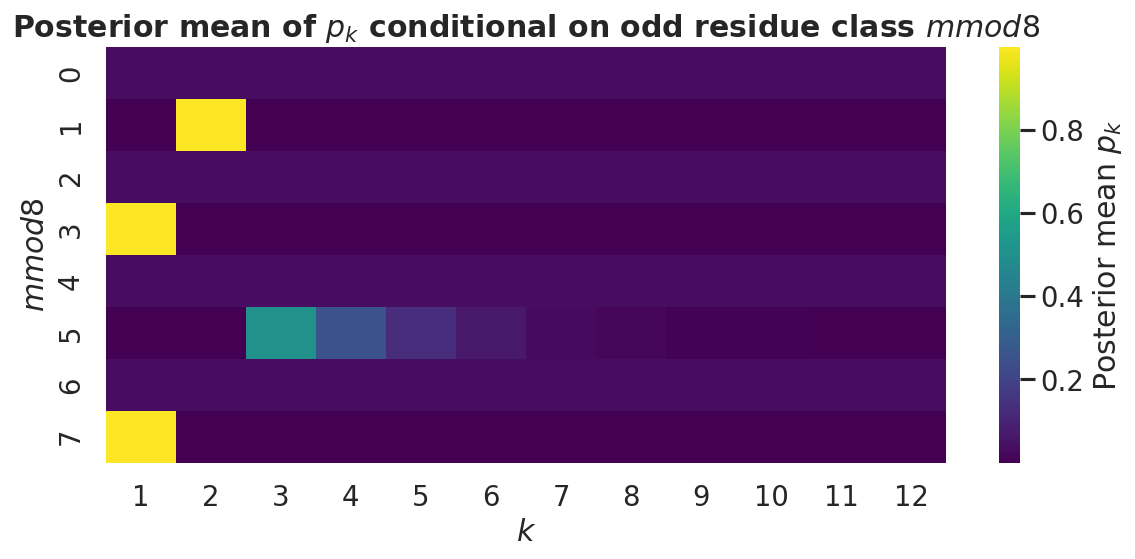

In [ ]:
# ---------- G1: geometric 2^{-k} truncated ----------
pk_g1 = np.zeros(K_max + 1, dtype=float)
for k in range(1, K_max):
    pk_g1[k] = 0.5 ** k
pk_g1[K_max] = 1.0 - pk_g1.sum()
pk_g1 = pk_g1 / pk_g1.sum()
cdf_g1 = np.cumsum(pk_g1)
cdf_g1[-1] = 1.0

# ---------- G2: posterior mean ----------
pk_g2 = p_post_mean.copy()
pk_g2[0] = 0.0
pk_g2 = pk_g2 / pk_g2.sum()
cdf_g2 = np.cumsum(pk_g2)
cdf_g2[-1] = 1.0

print("Checks:")
print(" G1 sum:", pk_g1.sum(), "E[K]:", sum(k*pk_g1[k] for k in range(1, K_max+1)))
print(" G2 sum:", pk_g2.sum(), "E[K]:", sum(k*pk_g2[k] for k in range(1, K_max+1)))

# ---------- G3: p_k conditional on odd residue class mod 8 ----------
counts_rk = np.zeros((8, K_max + 1), dtype=np.int64)
res8 = (odd % 8).astype(np.int64)
for r in range(8):
    mask = (res8 == r)
    if mask.any():
        cc = np.bincount(K_cap[mask], minlength=K_max + 1)
        cc[0] = 0
        counts_rk[r, :] = cc

alpha0_r = 1.0
alpha_post_rk = counts_rk.astype(float) + alpha0_r
alpha_post_rk[:, 0] = 0.0
pk_rk = alpha_post_rk / alpha_post_rk.sum(axis=1, keepdims=True)
cdf_r = np.cumsum(pk_rk, axis=1)
cdf_r[:, -1] = 1.0

# Heatmap (k=1..12)
k_plot = 12
plt.figure(figsize=(10, 5))
sns.heatmap(
    pk_rk[:, 1:k_plot+1],
    cmap="viridis",
    cbar_kws={"label": r"Posterior mean $p_k$"},
    yticklabels=[str(r) for r in range(8)],
    xticklabels=[str(k) for k in range(1, k_plot+1)]
)
plt.title(r"Posterior mean of $p_k$ conditional on odd residue class $m mod 8$")
plt.xlabel(r"$k$")
plt.ylabel(r"$m mod 8$")
plt.tight_layout()

plt.show()


## M2.4 — Posterior predictive check (PPC): distributional overlay


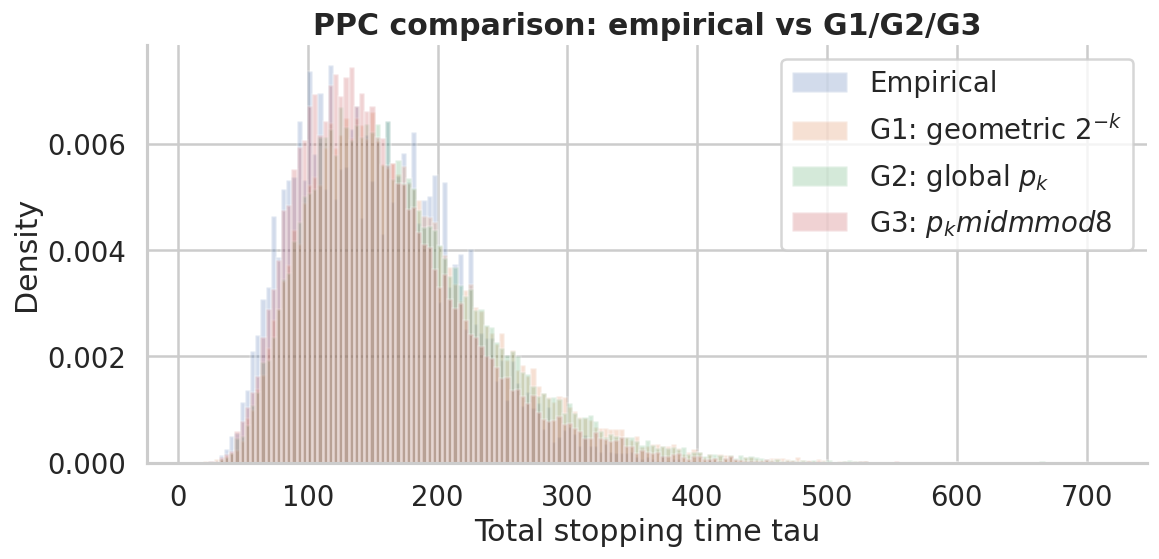

Means: Emp 154.96356666666668 | G1 172.72346666666667 | G2 172.12286666666665 | G3 157.61986666666667


In [ ]:
def sample_k_from_cdf(rng: np.random.Generator, cdf: np.ndarray) -> int:
    u = rng.random()
    return int(np.searchsorted(cdf, u, side="right"))

def tau_stochastic_iidK(n0: int, rng: np.random.Generator, cdf: np.ndarray, max_steps: int = 200_000) -> int:
    n = int(n0)
    steps = 0
    while n != 1 and steps < max_steps:
        if (n & 1) == 0:
            n >>= 1
            steps += 1
        else:
            k = sample_k_from_cdf(rng, cdf)
            if k == 0: k = 1
            denom = 1 << k
            n = int(round((3*n + 1) / denom))
            if n < 1: n = 1
            if (n & 1) == 0 and n != 1:
                n += 1
            steps += 1 + k
    return steps

def tau_stochastic_g3(n0: int, rng: np.random.Generator, cdf_r: np.ndarray, max_steps: int = 200_000) -> int:
    n = int(n0)
    steps = 0
    while n != 1 and steps < max_steps:
        if (n & 1) == 0:
            n >>= 1
            steps += 1
        else:
            r = n % 8
            k = sample_k_from_cdf(rng, cdf_r[r])
            if k == 0: k = 1
            denom = 1 << k
            n = int(round((3*n + 1) / denom))
            if n < 1: n = 1
            if (n & 1) == 0 and n != 1:
                n += 1
            steps += 1 + k
    return steps
# PPC
rng = np.random.default_rng(7)
N_ppc = 30_000
idx = rng.choice(df.index.to_numpy(), size=N_ppc, replace=False)
tau_true = df.loc[idx, "tau"].to_numpy(dtype=np.int32)

starts = rng.integers(1, N + 1, size=N_ppc, dtype=np.int64)

tau_g1 = np.array([tau_stochastic_iidK(int(s), rng, cdf_g1) for s in starts], dtype=np.int32)
tau_g2 = np.array([tau_stochastic_iidK(int(s), rng, cdf_g2) for s in starts], dtype=np.int32)
tau_g3 = np.array([tau_stochastic_g3 (int(s), rng, cdf_r ) for s in starts], dtype=np.int32)

bins = np.arange(min(tau_true.min(), tau_g1.min(), tau_g2.min(), tau_g3.min()) - 0.5,
                 max(tau_true.max(), tau_g1.max(), tau_g2.max(), tau_g3.max()) + 1.5,
                 4)

plt.figure(figsize=(10,5))
plt.hist(tau_true, bins=bins, density=True, alpha=0.25, label="Empirical")
plt.hist(tau_g1,  bins=bins, density=True, alpha=0.25, label=r"G1: geometric $2^{-k}$")
plt.hist(tau_g2,  bins=bins, density=True, alpha=0.25, label=r"G2: global $p_k$")
plt.hist(tau_g3,  bins=bins, density=True, alpha=0.25, label=r"G3: $p_k mid m mod 8$")
plt.title(r"PPC comparison: empirical vs G1/G2/G3")
plt.xlabel(r"Total stopping time tau")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()



print("Means:",
      "Emp", float(tau_true.mean()),
      "| G1", float(tau_g1.mean()),
      "| G2", float(tau_g2.mean()),
      "| G3", float(tau_g3.mean()))


## M2.6 — Predictive scoring (optional): hit-based log score + Wasserstein


In [ ]:
# Cella G-Score-Numba — Log score + W1 per G2 e G3 con N_SCORE=50k

from numba import njit
from scipy.stats import wasserstein_distance
import numpy as np

MAX_STEPS_GEN = 200_000   # stesso cutoff usato nel resto
S_MC          = 40        # numero di repliche Monte Carlo per lo score
N_SCORE       = 50_000    # vogliamo allinearci a N_test = 50k

# 1) Funzioni Numba per il generatore i.i.d. (G2)

@njit
def tau_stochastic_iidK_single(n0: int, cdf: np.ndarray, max_steps: int) -> int:
    n = int(n0)
    steps = 0
    while n != 1 and steps < max_steps:
        if (n & 1) == 0:
            n >>= 1
            steps += 1
        else:
            u = np.random.random()
            k = int(np.searchsorted(cdf, u))
            if k == 0:
                k = 1
            denom = 1 << k
            n = int(round((3 * n + 1) / denom))
            if n < 1:
                n = 1
            if (n & 1) == 0 and n != 1:
                n += 1
            steps += 1 + k
    return steps

@njit
def mc_hits_iidK_numba(n_test: np.ndarray,
                       y_test: np.ndarray,
                       cdf: np.ndarray,
                       S: int,
                       max_steps: int) -> np.ndarray:
    N = n_test.shape[0]
    hits = np.zeros(N, dtype=np.int32)
    for s in range(S):
        for i in range(N):
            n0 = int(n_test[i])
            n = n0
            steps = 0
            while n != 1 and steps < max_steps:
                if (n & 1) == 0:
                    n >>= 1
                    steps += 1
                else:
                    u = np.random.random()
                    k = int(np.searchsorted(cdf, u))
                    if k == 0:
                        k = 1
                    denom = 1 << k
                    n = int(round((3 * n + 1) / denom))
                    if n < 1:
                        n = 1
                    if (n & 1) == 0 and n != 1:
                        n += 1
                    steps += 1 + k
            if steps == int(y_test[i]):
                hits[i] += 1
    return hits

@njit
def one_draw_iidK_numba(n_test: np.ndarray,
                        cdf: np.ndarray,
                        max_steps: int) -> np.ndarray:
    N = n_test.shape[0]
    y_pred = np.zeros(N, dtype=np.int32)
    for i in range(N):
        n0 = int(n_test[i])
        n = n0
        steps = 0
        while n != 1 and steps < max_steps:
            if (n & 1) == 0:
                n >>= 1
                steps += 1
            else:
                u = np.random.random()
                k = int(np.searchsorted(cdf, u))
                if k == 0:
                    k = 1
                denom = 1 << k
                n = int(round((3 * n + 1) / denom))
                if n < 1:
                    n = 1
                if (n & 1) == 0 and n != 1:
                    n += 1
                steps += 1 + k
        y_pred[i] = steps
    return y_pred

# -----------------------------
# 2) Funzioni Numba per G3 (p_k dipende da n mod 8)
# -----------------------------

@njit
def tau_stochastic_g3_single(n0: int,
                             cdf_r: np.ndarray,
                             max_steps: int) -> int:
    n = int(n0)
    steps = 0
    while n != 1 and steps < max_steps:
        if (n & 1) == 0:
            n >>= 1
            steps += 1
        else:
            r = n % 8
            cdf = cdf_r[r]
            u = np.random.random()
            k = int(np.searchsorted(cdf, u))
            if k == 0:
                k = 1
            denom = 1 << k
            n = int(round((3 * n + 1) / denom))
            if n < 1:
                n = 1
            if (n & 1) == 0 and n != 1:
                n += 1
            steps += 1 + k
    return steps

@njit
def mc_hits_g3_numba(n_test: np.ndarray,
                     y_test: np.ndarray,
                     cdf_r: np.ndarray,
                     S: int,
                     max_steps: int) -> np.ndarray:
    N = n_test.shape[0]
    hits = np.zeros(N, dtype=np.int32)
    for s in range(S):
        for i in range(N):
            n0 = int(n_test[i])
            n = n0
            steps = 0
            while n != 1 and steps < max_steps:
                if (n & 1) == 0:
                    n >>= 1
                    steps += 1
                else:
                    r = n % 8
                    cdf = cdf_r[r]
                    u = np.random.random()
                    k = int(np.searchsorted(cdf, u))
                    if k == 0:
                        k = 1
                    denom = 1 << k
                    n = int(round((3 * n + 1) / denom))
                    if n < 1:
                        n = 1
                    if (n & 1) == 0 and n != 1:
                        n += 1
                    steps += 1 + k
            if steps == int(y_test[i]):
                hits[i] += 1
    return hits

@njit
def one_draw_g3_numba(n_test: np.ndarray,
                      cdf_r: np.ndarray,
                      max_steps: int) -> np.ndarray:
    N = n_test.shape[0]
    y_pred = np.zeros(N, dtype=np.int32)
    for i in range(N):
        n0 = int(n_test[i])
        n = n0
        steps = 0
        while n != 1 and steps < max_steps:
            if (n & 1) == 0:
                n >>= 1
                steps += 1
            else:
                r = n % 8
                cdf = cdf_r[r]
                u = np.random.random()
                k = int(np.searchsorted(cdf, u))
                if k == 0:
                    k = 1
                denom = 1 << k
                n = int(round((3 * n + 1) / denom))
                if n < 1:
                    n = 1
                if (n & 1) == 0 and n != 1:
                    n += 1
                steps += 1 + k
        y_pred[i] = steps
    return y_pred

# -----------------------------
# 3) Selezione del test set (50k) e scoring vero
# -----------------------------

# Usiamo esattamente 50k punti dal tuo df_test
rng = np.random.default_rng(999)
if len(df_test) < N_SCORE:
    N_SCORE = len(df_test)
sub_idx = rng.choice(np.arange(len(df_test)), size=N_SCORE, replace=False)

n_test_sub = df_test.iloc[sub_idx]["n"].to_numpy(dtype=np.int64)
y_test_sub = df_test.iloc[sub_idx]["tau"].to_numpy(dtype=np.int64)

# ---- G2: i.i.d. K con p_k = posterior mean globale ----
np.random.seed(2026)  # per riproducibilità dentro Numba
hits_g2 = mc_hits_iidK_numba(n_test_sub, y_test_sub, cdf_g2, S_MC, MAX_STEPS_GEN)
p_hat_g2 = hits_g2.astype(np.float64) / float(S_MC)
eps = 1e-12
log_score_g2 = float(np.sum(np.log(p_hat_g2 + eps)))

np.random.seed(2026)
y_pred_g2 = one_draw_iidK_numba(n_test_sub, cdf_g2, MAX_STEPS_GEN)
w1_g2 = float(wasserstein_distance(y_test_sub, y_pred_g2))

print("G2 log score (N=50k):", log_score_g2,
      "| avg per obs:", log_score_g2 / N_SCORE,
      "| W1:", w1_g2)

# ---- G3: K dipende da n mod 8 ----
np.random.seed(2027)
hits_g3 = mc_hits_g3_numba(n_test_sub, y_test_sub, cdf_r, S_MC, MAX_STEPS_GEN)
p_hat_g3 = hits_g3.astype(np.float64) / float(S_MC)
log_score_g3 = float(np.sum(np.log(p_hat_g3 + eps)))

np.random.seed(2027)
y_pred_g3 = one_draw_g3_numba(n_test_sub, cdf_r, MAX_STEPS_GEN)
w1_g3 = float(wasserstein_distance(y_test_sub, y_pred_g3))

print("G3 log score (N=50k):", log_score_g3,
      "| avg per obs:", log_score_g3 / N_SCORE,
      "| W1:", w1_g3)

print("NOTE: generative scores computed on N_SCORE =",
      N_SCORE, "test points with S_MC =", S_MC, "MC replicates.")


G2 log score (N=50k): -1166773.3827780066 | avg per obs: -23.335467655560134 | W1: 17.193980000000003
G3 log score (N=50k): -1085672.3534863759 | avg per obs: -21.71344706972752 | W1: 5.432740000000004
NOTE: generative scores computed on N_SCORE = 50000 test points with S_MC = 40 MC replicates.
